In [34]:
import os
import pandas as pd
import nltk
from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Concatenate, Dropout, LSTM, GRU
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
from google.colab import files

# Загружаем файл
uploaded = files.upload()

Saving main_df_with_word2vec.csv to main_df_with_word2vec.csv


In [22]:
df = pd.read_csv("main_df_with_word2vec.csv")
df.head()

,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,[-0.08585548 0.20660125 0.02343356 0.086243...,2024-10-09,5,54,0,0,0
1,1,[-0.09014589 0.23172413 0.02707928 0.093920...,2024-10-09,5,195,0,0,0
2,2,[-0.04612122 0.11718315 0.01649446 0.054378...,2024-10-09,5,17,0,0,0
3,3,[-0.12741375 0.31738162 0.03834668 0.127134...,2024-10-09,5,33,0,0,0
4,4,[-0.07455595 0.20783949 0.02374218 0.083927...,2024-10-09,5,15,0,0,0


In [23]:
df['User review'] = df['User review'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))
df = df.drop(columns=["Unnamed: 0"])
df.head()

,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,"[-0.08585548, 0.20660125, 0.02343356, 0.086243...",2024-10-09,5,54,0,0,0
1,"[-0.09014589, 0.23172413, 0.02707928, 0.093920...",2024-10-09,5,195,0,0,0
2,"[-0.04612122, 0.11718315, 0.01649446, 0.054378...",2024-10-09,5,17,0,0,0
3,"[-0.12741375, 0.31738162, 0.03834668, 0.127134...",2024-10-09,5,33,0,0,0
4,"[-0.07455595, 0.20783949, 0.02374218, 0.083927...",2024-10-09,5,15,0,0,0


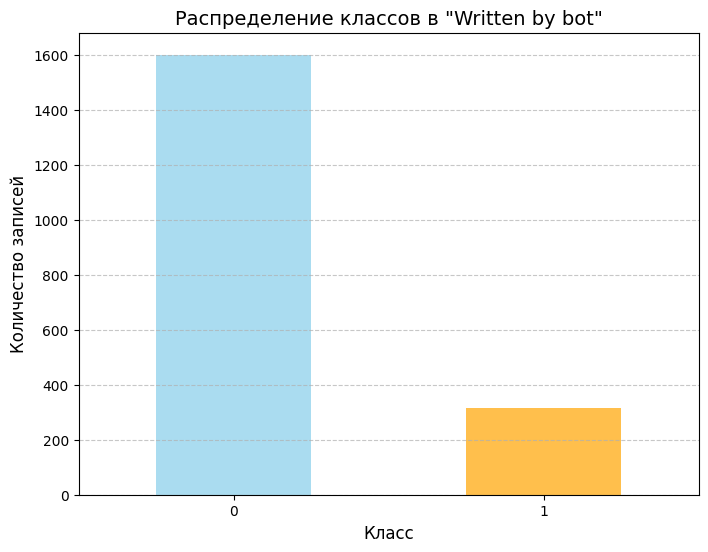

In [24]:
df_balance = df.copy()
class_counts = df['Written by bot'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
plt.title('Распределение классов в "Written by bot"', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
df['Review date'] = pd.to_datetime(df['Review date'], errors='coerce')
df['year'] = df['Review date'].dt.year
df['month'] = df['Review date'].dt.month
df['day'] = df['Review date'].dt.day
target = df['Written by bot']
df = df.drop(columns=["Review date"])
df.head()

,User review,Star review,Text length,Has media,Has answer,Written by bot,year,month,day
0,"[-0.08585548, 0.20660125, 0.02343356, 0.086243...",5,54,0,0,0,2024,10,9
1,"[-0.09014589, 0.23172413, 0.02707928, 0.093920...",5,195,0,0,0,2024,10,9
2,"[-0.04612122, 0.11718315, 0.01649446, 0.054378...",5,17,0,0,0,2024,10,9
3,"[-0.12741375, 0.31738162, 0.03834668, 0.127134...",5,33,0,0,0,2024,10,9
4,"[-0.07455595, 0.20783949, 0.02374218, 0.083927...",5,15,0,0,0,2024,10,9


Исходное распределение классов: Counter({0: 1602, 1: 314})


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


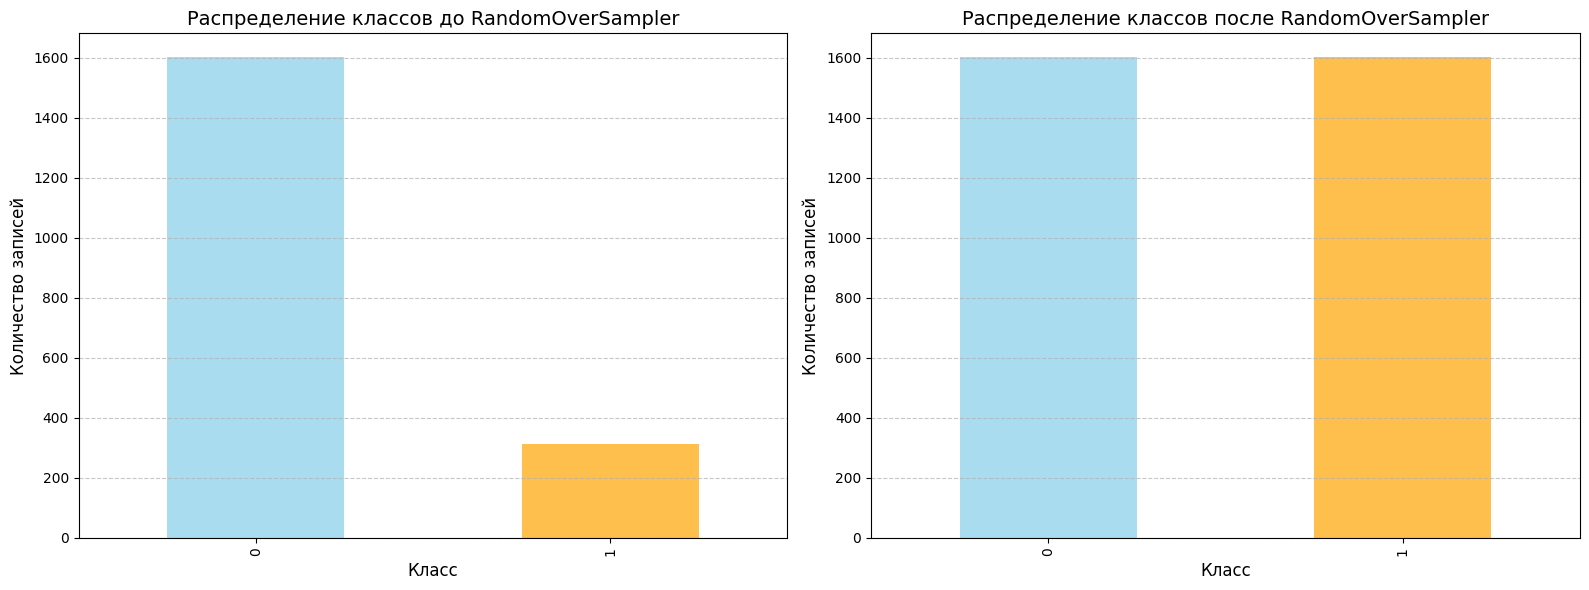

In [30]:
df["User review"] = np.stack(df["User review"].values)
y = df['Written by bot']

X = df.drop(columns=['Written by bot']).values

print("Исходное распределение классов:", Counter(y))

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_counts_before = y.value_counts()
class_counts_before.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[0])
axes[0].set_title('Распределение классов до RandomOverSampler', fontsize=14)
axes[0].set_xlabel('Класс', fontsize=12)
axes[0].set_ylabel('Количество записей', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

class_counts_after = pd.Series(y_ros).value_counts()
class_counts_after.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[1])
axes[1].set_title('Распределение классов после RandomOverSampler', fontsize=14)
axes[1].set_xlabel('Класс', fontsize=12)
axes[1].set_ylabel('Количество записей', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [31]:
X_smote_df = pd.DataFrame(X_ros, columns=df.drop(columns=['Written by bot']).columns)
X_smote_text = X_smote_df['User review']
X_smote_numeric = X_smote_df.drop(columns=['User review'])
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_smote_text, X_smote_numeric, y_ros, test_size=0.2, random_state=42, stratify=y_ros
)

# Проверяем размеры выборок
print(f"Размеры текстовых данных:")
print(f"X_train_text: {X_train_text.shape}, X_test_text: {X_test_text.shape}")
print(f"Размеры числовых данных:")
print(f"X_train_num: {X_train_num.shape}, X_test_num: {X_test_num.shape}")
print(f"Размеры меток:")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Размеры текстовых данных:
X_train_text: (2563,), X_test_text: (641,)
Размеры числовых данных:
X_train_num: (2563, 7), X_test_num: (641, 7)
Размеры меток:
y_train: (2563,), y_test: (641,)


GlobalPooling2D

In [32]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [43]:
import keras_tuner as kt

save_directory = "pooling_directory"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

def build_model(hp):

    maxlen = 1000
    text_input = Input(shape=(maxlen,), name='text_input')
    x_text = Embedding(1001, hp.Int('embedding_dim', min_value=16, max_value=128, step=16))(text_input)
    x_text = GlobalAveragePooling1D()(x_text)
    x_text = Dense(hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu')(x_text)

    # Входные данные для числовых признаков
    num_input = Input(shape=(7,), name='num_input')
    x_num = Dense(32, activation='relu')(num_input)

    # Слияние текстовых и числовых признаков
    combined = Concatenate()([x_text, x_num])

    # Основное тело нейросети
    x = combined
    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', min_value=0.001, max_value=0.1, step=0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                  activation='relu',
                  kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)


    # Выходной слой
    output = Dense(2, activation='softmax')(x)

    # Компиляция модели
    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='pooling_directory',
    project_name='hyperparameter_tuning'
)

tuner.search(
    [X_train_text, X_train_num], y_train,
    epochs=10,
    validation_data=([X_test_text, X_test_num], y_test)
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


model = tuner.hypermodel.build(best_hps)

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)


test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Reloading Tuner from pooling_directory/hyperparameter_tuning/tuner0.json
{'embedding_dim': 48, 'dense_units': 80, 'num_layers': 3, 'reg_type_0': 'l2', 'reg_value_0': 0.07300000000000001, 'units_0': 128, 'dropout_0': 0.5, 'optimizer': 'rmsprop', 'reg_type_1': 'l2', 'reg_value_1': 0.081, 'units_1': 64, 'dropout_1': 0.2, 'reg_type_2': 'l1', 'reg_value_2': 0.038, 'units_2': 128, 'dropout_2': 0.5, 'reg_type_3': 'l1', 'reg_value_3': 0.074, 'units_3': 128, 'dropout_3': 0.5, 'reg_type_4': 'l1', 'reg_value_4': 0.081, 'units_4': 256, 'dropout_4': 0.2, 'reg_type_5': 'l1', 'reg_value_5': 0.07200000000000001, 'units_5': 256, 'dropout_5': 0.30000000000000004, 'reg_type_6': 'l1', 'reg_value_6': 0.093, 'units_6': 192, 'dropout_6': 0.30000000000000004, 'reg_type_7': 'l1_l2', 'reg_value_7': 0.07100000000000001, 'units_7': 64, 'dropout_7': 0.4, 'reg_type_8': 'l1_l2', 'reg_value_8': 0.018000000000000002, 'units_8': 256, 'dropout_8': 0.5, 'reg_type_9': 'l1', 'reg_value_9': 0.004, 'units_9': 64, 'dropout_9'

In [38]:
!zip -r pooling_directory.zip pooling_directory
from google.colab import files
files.download('pooling_directory.zip')

  adding: pooling_directory/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0017/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0017/checkpoint.weights.h5 (deflated 51%)
  adding: pooling_directory/hyperparameter_tuning/trial_0017/build_config.json (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0017/trial.json (deflated 90%)
  adding: pooling_directory/hyperparameter_tuning/trial_0014/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0014/checkpoint.weights.h5 (deflated 42%)
  adding: pooling_directory/hyperparameter_tuning/trial_0014/build_config.json (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0014/trial.json (deflated 89%)
  adding: pooling_directory/hyperparameter_tuning/trial_0023/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0023/checkpoint.weights.h5 (deflated 47%)
  adding: pooling_direct

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LSTM

In [44]:
save_directory = "lstm_directory"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

def build_model(hp):
    maxlen = 1000
    text_input = Input(shape=(maxlen,), name='text_input')

    embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=128, step=16)
    x_text = Embedding(input_dim=1001, output_dim=embedding_dim)(text_input)

    lstm_units = hp.Int('lstm_units', min_value=16, max_value=128, step=16)
    x_text = LSTM(lstm_units)(x_text)
    x_text = Dense(64, activation='relu')(x_text)

    num_input = Input(shape=(7,), name='num_input')
    x_num = Dense(32, activation='relu')(num_input)

    combined = Concatenate()([x_text, x_num])

    # Основное тело нейросети
    x = combined
    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', min_value=0.001, max_value=0.1, step=0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                  activation='relu',
                  kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    # Выходной слой
    output = Dense(2, activation='softmax')(x)

    # Компиляция модели
    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Создаем Tuner для поиска гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='lstm_directory',
    project_name='hyperparameter_tuning'
)

tuner.search(
    [X_train_text, X_train_num], y_train,
    epochs=10,
    validation_data=([X_test_text, X_test_num], y_test)
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


model = tuner.hypermodel.build(best_hps)

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)


test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Reloading Tuner from lstm_directory/hyperparameter_tuning/tuner0.json
{'embedding_dim': 32, 'lstm_units': 16, 'num_layers': 1, 'reg_type_0': 'l1_l2', 'reg_value_0': 0.006, 'units_0': 256, 'dropout_0': 0.2, 'optimizer': 'adam', 'reg_type_1': 'l1_l2', 'reg_value_1': 0.011, 'units_1': 128, 'dropout_1': 0.5, 'reg_type_2': 'l1', 'reg_value_2': 0.044000000000000004, 'units_2': 128, 'dropout_2': 0.2, 'reg_type_3': 'l1_l2', 'reg_value_3': 0.010000000000000002, 'units_3': 256, 'dropout_3': 0.5, 'reg_type_4': 'l2', 'reg_value_4': 0.09, 'units_4': 64, 'dropout_4': 0.4, 'reg_type_5': 'l1', 'reg_value_5': 0.09, 'units_5': 128, 'dropout_5': 0.30000000000000004, 'reg_type_6': 'l1_l2', 'reg_value_6': 0.002, 'units_6': 256, 'dropout_6': 0.4, 'reg_type_7': 'l2', 'reg_value_7': 0.098, 'units_7': 128, 'dropout_7': 0.4, 'reg_type_8': 'l2', 'reg_value_8': 0.044000000000000004, 'units_8': 192, 'dropout_8': 0.5, 'reg_type_9': 'l1', 'reg_value_9': 0.056, 'units_9': 128, 'dropout_9': 0.1, 'tuner/epochs': 10, 't

GRU

In [45]:
save_directory = "gru_directory"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

def build_model(hp):
    maxlen = 1000
    text_input = Input(shape=(maxlen,), name='text_input')

    embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=128, step=16)
    x_text = Embedding(input_dim=1001, output_dim=embedding_dim)(text_input)

    gru_units = hp.Int('gru_units', min_value=16, max_value=128, step=16)
    x_text = GRU(gru_units)(x_text)
    x_text = Dense(64, activation='relu')(x_text)

    num_input = Input(shape=(7,), name='num_input')
    x_num = Dense(32, activation='relu')(num_input)

    combined = Concatenate()([x_text, x_num])

    # Основное тело нейросети
    x = combined
    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', min_value=0.001, max_value=0.1, step=0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                  activation='relu',
                  kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    # Выходной слой
    output = Dense(2, activation='softmax')(x)

    # Компиляция модели
    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='gru_directory',
    project_name='hyperparameter_tuning'
)

tuner.search(
    [X_train_text, X_train_num], y_train,
    epochs=10,
    validation_data=([X_test_text, X_test_num], y_test)
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


model = tuner.hypermodel.build(best_hps)

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)


test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Reloading Tuner from gru_directory/hyperparameter_tuning/tuner0.json
{'embedding_dim': 112, 'gru_units': 112, 'num_layers': 1, 'reg_type_0': 'l2', 'reg_value_0': 0.032, 'units_0': 128, 'dropout_0': 0.30000000000000004, 'optimizer': 'adam', 'reg_type_1': 'l2', 'reg_value_1': 0.065, 'units_1': 192, 'dropout_1': 0.2, 'reg_type_2': 'l1', 'reg_value_2': 0.099, 'units_2': 64, 'dropout_2': 0.1, 'reg_type_3': 'l1_l2', 'reg_value_3': 0.089, 'units_3': 64, 'dropout_3': 0.30000000000000004, 'reg_type_4': 'l1_l2', 'reg_value_4': 0.08700000000000001, 'units_4': 192, 'dropout_4': 0.2, 'reg_type_5': 'l1_l2', 'reg_value_5': 0.005, 'units_5': 128, 'dropout_5': 0.4, 'reg_type_6': 'l2', 'reg_value_6': 0.030000000000000002, 'units_6': 64, 'dropout_6': 0.30000000000000004, 'reg_type_7': 'l2', 'reg_value_7': 0.07300000000000001, 'units_7': 192, 'dropout_7': 0.4, 'reg_type_8': 'l1', 'reg_value_8': 0.047, 'units_8': 192, 'dropout_8': 0.2, 'reg_type_9': 'l1', 'reg_value_9': 0.069, 'units_9': 64, 'dropout_9': 0